In [1]:
from sys import path 
path.append("../")

from src.data.smile import SmileData
from src.utils.inputation import filling_mean
from numpy import ndarray

from pandas import IndexSlice, concat, DataFrame, MultiIndex
from numpy import swapaxes, arange
from pandas import DataFrame, Series, MultiIndex, concat
from pandas import MultiIndex
from scipy.stats import pearsonr, spearmanr, kendalltau
from numpy import array
import ipywidgets as widgets
# from src.utils import slice_user_over_experiment_time
# from src.utils.correlation import calculate_correlation_coefficients
# from scipy.stats import pearsonr, spearmanr, kendalltau
# from time import time
# from tqdm.notebook import tqdm
from seaborn import heatmap
from matplotlib.pyplot import figure, savefig, show, title, xlabel, legend, xticks, tight_layout
# from numpy import array, asarray, ndarray, mean
# from copy import deepcopy

from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
ecg_features_names: list[str] = [
    "HR mean",
    "HR HRV std R-R",
    "HR RMSE R-R diff",
    "HR low freq",
    "HR high freq",
    "HR ratio low/high freq",
    "HR ratio very low/low freq",
    "HR cycle",
]

gsr_features_names: list[str] = [
    "GSR avg",
    "GSR signal power phasic",
    "GSR response rate",
    "GSR second difference",
    "GSR #responses",
    "GSR magnitude",
    "GSR duration",
    "GSR area",]

st_features_names: list[str] = [
    "ST avg",
    "ST std",
    "ST slope fitted",
    "ST median"]

features: list[tuple[str, str]] = [
            ("hand_crafted_features", "ECG_features"),
            ("hand_crafted_features", "GSR_features"),
            ("hand_crafted_features", "ST_features"),
            ("deep_features", "ECG_features_C"),
            ("deep_features", "ECG_features_T"),
        ]

# Introduction

While the objective of the challenge is to create an ML-based system to recognize stress from the data given, which are timeseries of extracted features, we believe it is also important to perform some preliminary analysis. 

Here, some basic correlations are explored. The idea is to see:
1. Which feature, especially the **hand crafted** ones, is more correlated with the stress label. 
2. Which times are more correlated w/ the stress label.
This analysis can be performed either with the separate or the aggregated labels, even if I do not expect to see many differences.

# Preliminary Analysis

Here we explore a little the data. The idea is to see if there are some problems or interesting patterns, aside from the 111 NaN points which have been imputed.

In [8]:
path_to_data: str = "../data.nosync/dataset_smile_challenge.npy"
data = SmileData(path_to_data=path_to_data, test=False)
data.separate_skin_temperature()
data.remove_flatlines()
hand_crafted_data: ndarray = data.get_handcrafted_features(masking=False, joined=True)
deep_data: ndarray = data.get_deep_features(masking=False, joined=True)
labels: ndarray = data.get_labels()

In [9]:
print(hand_crafted_data.shape)
print(deep_data.shape)
print(labels.shape)

(1525, 60, 20)
(1525, 60, 320)
(1525,)


In order to be able to have a nice plot, the 3-dimensional data has to be mapped to a multi-indexed 2-dimensional pandas dataframe.

In [4]:
from pandas import MultiIndex
hand_crafted_data = swapaxes(hand_crafted_data, 1, 2)
hand_crafted_data = hand_crafted_data.reshape(hand_crafted_data.shape[0],-1)
hand_crafted_data: DataFrame = DataFrame(hand_crafted_data)

all_features_names: list[str] = ecg_features_names + gsr_features_names + st_features_names
multi_index = MultiIndex.from_tuples([(feat, i) for feat in all_features_names for i in range(60)], names=['feature', 'time'])
hand_crafted_data.columns = multi_index
hand_crafted_data.index.name = 'user'


In [5]:
hand_crafted_data.groupby(axis=1, level=1).describe()

count      mean       std  min       25%       50%  \
feature         time                                                        
mean heart rate 0     2069.0  0.083775  0.085030  0.0  0.018208  0.069540   
                1     2070.0  0.082798  0.084576  0.0  0.018781  0.068060   
                2     2069.0  0.084018  0.084133  0.0  0.017414  0.068979   
                3     2070.0  0.085555  0.087133  0.0  0.017678  0.068314   
                4     2069.0  0.083464  0.083473  0.0  0.016498  0.068492   
...                      ...       ...       ...  ...       ...       ...   
median ST       55    2070.0  0.012402  0.033850  0.0  0.000282  0.000901   
                56    2070.0  0.012015  0.032322  0.0  0.000287  0.000889   
                57    2070.0  0.011969  0.030255  0.0  0.000298  0.000878   
                58    2070.0  0.012065  0.031072  0.0  0.000295  0.000887   
                59    2070.0  0.012851  0.039028  0.0  0.000301  0.000882   

                           75%       max  
feature         time                      
mean heart rate 0     0.119214  0.754924  
                1     0.118141  0.729275  
                2     0.118880  0.618611  
                3     0.120104  0.639849  
                4     0.122262  0.762644  
...                        ...       ...  
median ST       55    0.013892  0.696564  
                56    0.013722  0.728351  
                57    0.013914  0.601510  
                58    0.014055  0.754429  
                59    0.014107  0.921921  

[1200 rows x 8 columns]

All of the features, it can be seen, are mostly in the range \[0,1\]: this is most likely because all of the features have been **normalized**.

However, there are some labels which have **flatlines**, here are some examples:

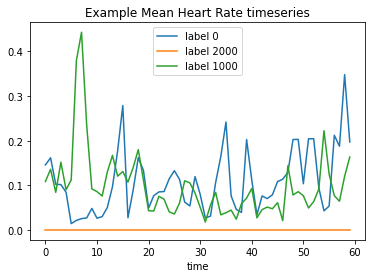

In [6]:
hand_crafted_data.loc[0, IndexSlice['mean heart rate', :]].droplevel(level=0).plot(label='label 0')
hand_crafted_data.loc[2000, IndexSlice['mean heart rate', :]].droplevel(level=0).plot(label='label 2000')
hand_crafted_data.loc[1000, IndexSlice['mean heart rate', :]].droplevel(level=0).plot(label='label 1000')
legend()
title("Example Mean Heart Rate timeseries")
show()

In [7]:
def get_flatline_count(feature_df: DataFrame) -> int:
    sum_of_val: DataFrame = feature_df.groupby(axis=0, level=0).apply(lambda x: sum(x.iloc[0, :]))
    sum_of_val: int = sum_of_val.value_counts().loc[0]
    return sum_of_val
hand_crafted_data.groupby(axis=1, level=0).apply(get_flatline_count)

feature
GSR #responses             391
GSR area                   391
GSR avg                    253
GSR duration               391
GSR magnitude              253
GSR response rate          391
GSR second difference      419
HR cycle                   227
RMSE R-R diff              227
avg ST                     253
high freq                  227
low freq                   227
mean heart rate            299
median ST                  253
ratio low/high freq        227
ratio very low/low freq    227
signal power GSR phasic    253
slope fitted ST            253
std HRV R-R                227
std ST                     254
dtype: int64

As can be seen, for each feature around 10% of the data is made of **flatlines**. From exploring the data by hand, it is known how these values are indeed **non-overlapping**. As such, we try to see how many labels **do not** have any **flatlines**.

In [8]:
from numpy import nan, full as filled_array
from pandas import Series


def intermediate_apply(x: DataFrame) -> DataFrame:
    return x.groupby(axis=1, level=0).apply(change_flatline_to_nan)


def change_flatline_to_nan(timeseries_df: DataFrame) -> DataFrame:
    if sum(timeseries_df.iloc[0, :]) == 0:
        timeseries_df.iloc[0, :] = nan
    return timeseries_df


hand_crafted_data_w_nan: DataFrame = (
    hand_crafted_data.groupby(axis=0, level=0)
    .parallel_apply(intermediate_apply)
    .droplevel(axis=0, level=1)
)


In [9]:
n_good: int = len(hand_crafted_data_w_nan.dropna(how='any'))
n_tot: int = len(hand_crafted_data_w_nan)
print('Total number of samples: %i\nSamples w/o flatlines: %i\nPercentage w flatlines: %.2f%%' %(n_tot,n_good, (100-n_good/n_tot*100)))

Total number of samples: 2070
Samples w/o flatlines: 1506
Percentage w flatlines: 27.25%


This is the number of rows without the flatlines: while much smaller than what we started with, it is something doable!

**NB**: dato che sto considerando i dati "sporchi", ovvero con anche la presenza di NaN, viene eliminata qualche riga in più.

I have tested the Machine Learning models w/ and w/o the **flatlines** and there is no statistical difference between them. 

Indeed, the only noticible difference is a higher standard deviation in the "smaller" set, which is indeed expected, but that's only it: even the same models show a similar performance.

# Correlation

## Separate/All

First, we analyse the correlation coefficient (Pearson default, but can be changed w/ a simple variable) for **timestep & feature**. Later, we aggregate on either of the two.

The analysis is performed only on the **train set** (since no labels on test set are given).

In [3]:
corr_chosen_wdg = widgets.Dropdown(
    options=['Pearson', 'Spearman', 'Kendall'],
    value='Pearson',
    description='Correlation Coefficient:',
    disabled=False,
)
corr_chosen_wdg

Dropdown(description='Correlation Coefficient:', options=('Pearson', 'Spearman', 'Kendall'), value='Pearson')

In [4]:
from typing import Callable
def get_correlation_method(corr_chosen: str) -> Callable:
    if corr_chosen == 'Pearson':
        return pearsonr
    elif corr_chosen == 'Spearman':
        return spearmanr
    elif corr_chosen == 'Kendall':
        return kendalltau
    else:
        raise ValueError('Unknown correlation method')
corr_chosen: str = corr_chosen_wdg.value    

correlation_method: Callable = get_correlation_method(corr_chosen=corr_chosen)

In [5]:
path_to_data: str = "../data.nosync/dataset_smile_challenge.npy"
data = SmileData(path_to_data=path_to_data, test=False)
data.separate_skin_temperature()


for feature_tuple in features:
    data.fill_missing_values(
        features=feature_tuple,
        filling_method=filling_mean,
    )


# data.remove_flatlines()
hand_crafted_data: ndarray = data.get_handcrafted_features(masking=False, joined=True)
deep_data: ndarray = data.get_deep_features(masking=False, joined=True)
labels: ndarray = data.get_labels()


In [6]:
hand_crafted_data = swapaxes(hand_crafted_data, 1, 2)
hand_crafted_data = hand_crafted_data.reshape(hand_crafted_data.shape[0], -1)
hand_crafted_data: DataFrame = DataFrame(hand_crafted_data)

all_features_names: list[str] = (
    ecg_features_names + gsr_features_names + st_features_names
)
multi_index = MultiIndex.from_tuples(
    [(feat, i) for feat in all_features_names for i in range(60)],
    names=["feature", "time"],
)
hand_crafted_data.columns = multi_index
hand_crafted_data.index.name = "user"


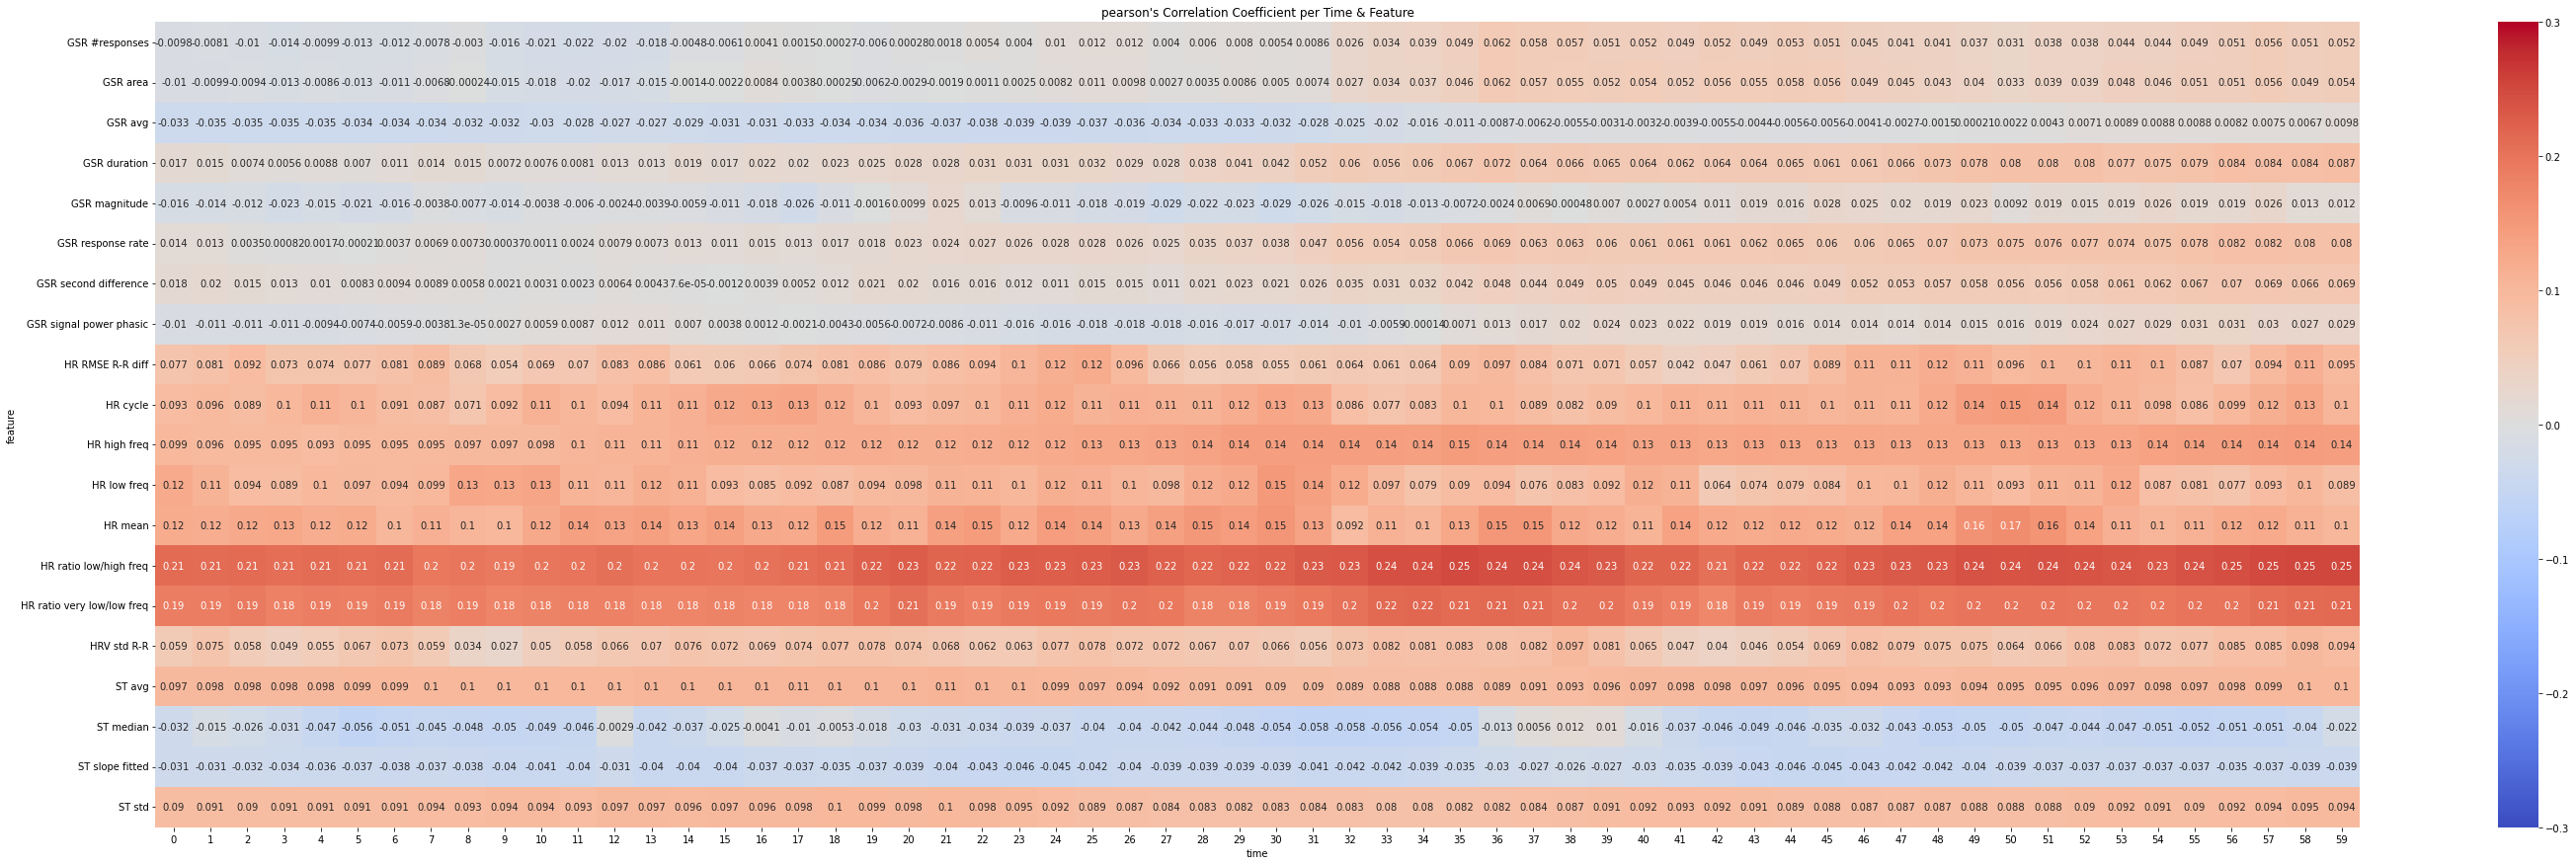

In [ ]:
correlation_results: DataFrame = (
    hand_crafted_data.groupby(axis=1, level=[0, 1])
    .apply(
        lambda data: Series(
            correlation_method(data.iloc[:, 0], labels), index=["value", "p-value"]
        )
    )
    .T
)

def change_orientation(x: DataFrame) -> DataFrame:
    time = x.index.get_level_values(1).unique()
    feature = x.index.get_level_values(0).unique()
    x = array(x)
    
    x = x.reshape(len(feature),len(time))

    x = DataFrame(x, index=feature, columns=time).T
    return x

df_to_save: DataFrame = change_orientation(correlation_results.loc[:, 'value']).T

figure(figsize=(50, 15))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=0.3, vmin=-0.3, center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
title(f"{corr_chosen}'s Correlation Coefficient per Time & Feature")
savefig(f'../visualizations/correlation_featureXtime_{corr_chosen}.pdf')

show()

From this plot it is very difficult to discern any useful information. However, it patterns are certainly evident: 
- There are two features, related to the Heart Rate, which have a higher correlation.
- For most variables, there is a somewhat increase correlation the **closer** to the correlation label one gets. This is certainly in line with the results from the challenge authors, who showed that last 10/15min are the most important ones.

## Aggregations

### Time

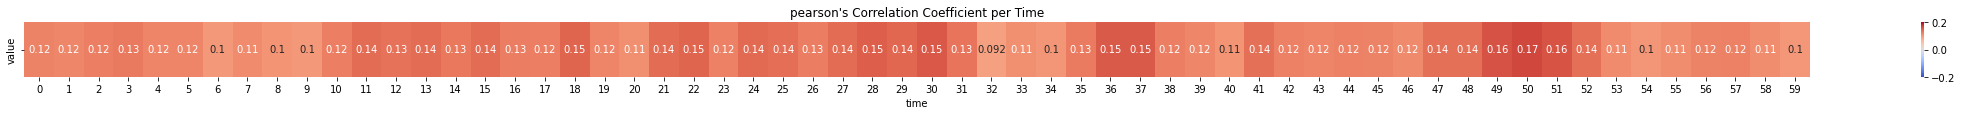

In [46]:
correlation_results: DataFrame = (
    hand_crafted_data.groupby(axis=1, level=1)
    .apply(
        lambda data: Series(
            correlation_method(data.iloc[:, 0], labels), index=["value", "p-value"]
        )
    )
)

df_to_save: DataFrame = correlation_results.loc[['value'], :]

figure(figsize=(40, 1))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=0.2, vmin=-0.2, center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
title(f"{corr_chosen}'s Correlation Coefficient per Time")
savefig(f'../visualizations/correlation_time_{corr_chosen}.pdf')

show()

From the analysis of the correlations in time, i.e. when considering all of the features together, there is no discernible pattern to be seen. Indeed, it only appears that it is not true the fact "the closer you are to the label, the more important the values are". But this can certainly be explained with the fact that some feature do not show this behaviour, since they may not be able to predict in any way the stress level!

### Features

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_23828/570061684.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  tight_layout()


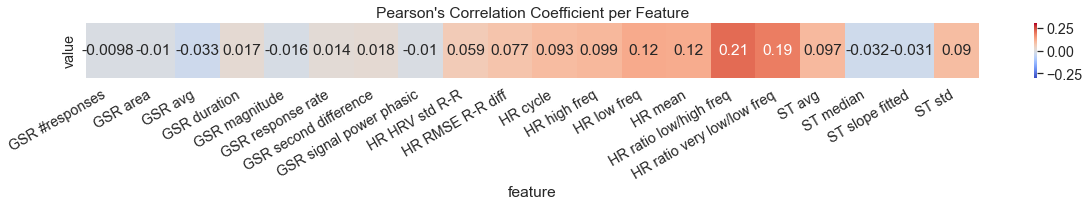

In [19]:
from seaborn import set as set_vars
correlation_results: DataFrame = (
    hand_crafted_data.groupby(axis=1, level=0)
    .apply(
        lambda data: Series(
            correlation_method(data.iloc[:, 0], labels), index=["value", "p-value"]
        )
    )
)

df_to_save: DataFrame = correlation_results.loc[['value'], :]

figure(figsize=(20, 1))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=0.3, vmin=-0.3, center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
title(f"{corr_chosen}'s Correlation Coefficient per Feature")
xticks(rotation=30, ha="right")
set_vars(font_scale=1.3)
tight_layout()
savefig(f'../visualizations/correlation_feature_{corr_chosen}.pdf', bbox_inches = "tight")

show()

As can be seen here, overall most of the features do not have a significant correlation: only a few feature related to the Heart Rate seem to be a little correlated. The use of other correlation coefficients tells a very similar story.

Overall, it can be seen that the sensor important is:
1. Heart Rate
2. Skin Temperature
3. GSR

This is indeed in line with the preliminary results with the "uniset" features, where the models that managed to achieve a somewhat decent accuracy were only those trained on HR and ST features.

### Feature sets

In [23]:
hand_crafted_data.columns = MultiIndex.from_tuples(
    [(col[0].split(" ")[0], col[0], col[1]) for col in hand_crafted_data.columns]
)


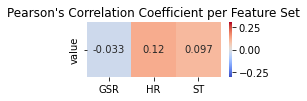

In [24]:
correlation_results: DataFrame = (
    hand_crafted_data.groupby(axis=1, level=0)
    .apply(
        lambda data: Series(
            correlation_method(data.iloc[:, 0], labels), index=["value", "p-value"]
        )
    )
)

df_to_save: DataFrame = correlation_results.loc[['value'], :]

figure(figsize=(3, 1))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=0.3, vmin=-0.3, center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
title(f"{corr_chosen}'s Correlation Coefficient per Feature Set")
savefig(f'../visualizations/correlation_featuresets_{corr_chosen}.pdf')

show()

Come this graph, and the p-values below, it can be discerned that only the GSR features are not interesting for the classification purpose. 

As such, in a multi-modal approach, it may be worth to use only the HR and ST features, and perform feature selection on them, discarding the other one.

As for reference, notice how the p-values are non-significant for the GSR, while they are for the other groups of fesatures.

In [78]:
correlation_results

,GSR,HR,ST
value,0.029989,1.492371e-01,0.099671
p-value,0.172600,8.852424e-12,0.000006
